# This notebook allows the recreation of figures in the paper based on the resources provided in the linked github (https://github.com/fowler-lab/tb-rnap-compensation.git)

Load all necessary packages

In [275]:
import pandas
import numpy
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu
from scipy.stats import bootstrap
import pylab
import scipy

from tqdm.autonotebook import tqdm

Define color function and plotting parameters

In [276]:
flierprops = dict(markerfacecolor='0.75', markersize=5,
              linestyle='none')
box_args = dict(notch = True, fliersize = 5, flierprops = flierprops, whis = [2.5, 97.55])
hist_args = dict(bins = 30, alpha = 0.5, stat = "percent", edgecolor='k', linewidth = 0.2)

#defines color palette based on keywords
def palette(color = "dark"):
    
    if color == "dark":
        colors = sns.color_palette("dark")
        my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
        return colors
    
    if color == "bright":
        colors = sns.color_palette("bright")
        my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
        return colors
    
    if color == "muted":
        colors = sns.color_palette("muted")
        my_cmap = ListedColormap(sns.color_palette(colors).as_hex())
        return colors

#takes a list of values as argument and gives the bootstrap median and CI
def my_bootstrap(data):
    
    median = round(data.median(), 2)
    CI = (round(bootstrap((data,), numpy.median, confidence_level = 0.95).confidence_interval.low, 2), 
          round(bootstrap((data,), numpy.median, confidence_level = 0.95).confidence_interval.high, 2))
    
    return median, CI

**Load all relevant data sets**

In [277]:
MUTATIONS = pandas.read_pickle('tb_rnap_compensation/tables/MUTATIONS.pkl.gz')
MUTATIONS.reset_index(inplace = True)
MUTATIONS = MUTATIONS.astype({'GENE':'str'})
MUTATIONS['GENE_MUTATION'] = MUTATIONS['GENE'] + '_' + MUTATIONS['MUTATION']

In [278]:
GENOMES = pandas.read_pickle('tb_rnap_compensation/tables/GENOMES.pkl.gz')

GENOMES

,SITEID,SUBJID,LABID,ISOLATENO,SEQREPS,BELONGS_GPI,PER_SAMPLE_VCF_PRESENT,REGENOTYPED_VCF_PRESENT,CLOCKWORK_VERSION,TBI_INDEX,...,IMAGE_MD5SUM,FTP_PATH,FTP_FILENAME_VCF,TREE_PATH,TREE_FILENAME_VCF,FASTQ_MD5SUMS,SEQTREAT_SAMPLE,MYKROBE_LINEAGE_NAME_1,MYKROBE_LINEAGE_NAME_2,ENA
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
site.02.subj.0958.lab.22A197.iso.1,02,0958,22A197,1,197,True,True,True,0.8.3,True,...,{'02-0958-22A197-1-14': 'a587bac9ad2a0ebd36274...,/well/bag/jeffk/release_staging/,00/01/41/00/14100/site.02.iso.1.subject.0958.l...,dat/CRyPTIC2/V2/02/0958/22A197/1/regenotyped/,site.02.subj.0958.lab.22A197.iso.1.v0.8.3.rege...,,False,Lineage 2,lineage2.2.1,ERS5301054
site.02.subj.0823.lab.2013241494.iso.1,02,0823,2013241494,1,241494,True,True,True,0.8.3,True,...,{'02-0823-2013241494-1-14': '698507bed7ff19268...,/well/bag/jeffk/release_staging/,00/01/41/43/14143/site.02.iso.1.subject.0823.l...,dat/CRyPTIC2/V2/02/0823/2013241494/1/regenotyped/,site.02.subj.0823.lab.2013241494.iso.1.v0.8.3....,,False,Lineage 2,lineage2.2.3,ERS5301097
site.02.subj.0359.lab.222018-14.iso.1,02,0359,222018-14,1,14222018,True,True,True,0.8.3,True,...,{'02-0359-222018-14-1-14': '39c28529c7564ce379...,/well/bag/jeffk/release_staging/,00/01/08/73/10873/site.02.iso.1.subject.0359.l...,dat/CRyPTIC2/V2/02/0359/222018-14/1/regenotyped/,site.02.subj.0359.lab.222018-14.iso.1.v0.8.3.r...,,False,Lineage 2,lineage2.2.3,ERS5298526
site.02.subj.0224.lab.2013221088.iso.1,02,0224,2013221088,1,13221088_2013221088,True,True,True,0.8.3,True,...,,/well/bag/jeffk/release_staging/,00/01/13/37/11337/site.02.iso.1.subject.0224.l...,dat/CRyPTIC2/V2/02/0224/2013221088/1/regenotyped/,site.02.subj.0224.lab.2013221088.iso.1.v0.8.3....,,False,Lineage 2,lineage2.2.5,ERS5300527
site.02.subj.0918.lab.22A153.iso.1,02,0918,22A153,1,153,True,True,True,0.8.3,True,...,{'02-0918-22A153-1-14': 'b48e27b23f8377c209854...,/well/bag/jeffk/release_staging/,00/01/40/62/14062/site.02.iso.1.subject.0918.l...,dat/CRyPTIC2/V2/02/0918/22A153/1/regenotyped/,site.02.subj.0918.lab.22A153.iso.1.v0.8.3.rege...,,False,Lineage 2,lineage2.2.3,ERS5301016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.10.subj.YA00023171.lab.YA00023171.iso.1,10,YA00023171,YA00023171,1,1,True,True,True,0.8.3,True,...,{'10-YA00023171-YA00023171-1-7': 'da79aa0564b0...,/well/bag/jeffk/release_staging/,00/00/31/24/3124/site.10.iso.1.subject.YA00023...,dat/CRyPTIC2/V2/10/YA00023171/YA00023171/1/reg...,site.10.subj.YA00023171.lab.YA00023171.iso.1.v...,,False,Lineage 4,lineage4.3.2.1,ERS5298216
site.10.subj.SADH00634109_S16.lab.DH00634109_S16.iso.1,10,SADH00634109_S16,DH00634109_S16,1,1,False,True,False,0.8.3,True,...,,/well/bag/jeffk/release_staging/,00/00/81/50/8150/site.10.iso.1.subject.SADH006...,dat/CRyPTIC2/V2/10/SADH00634109_S16/DH00634109...,site.10.subj.SADH00634109_S16.lab.DH00634109_S...,,False,Lineage 4,lineage4.3.2,ERS2400531
site.10.subj.H37RV_SA2437.lab.H37RV_SA2437.iso.1,10,H37RV_SA2437,H37RV_SA2437,1,1,False,True,False,0.8.3,True,...,,/well/bag/jeffk/release_staging/,00/01/45/29/14529/site.10.iso.1.subject.H37Rv_...,dat/CRyPTIC2/V2/10/H37RV_SA2437/H37RV_SA2437/1...,site.10.subj.H37RV_SA2437.lab.H37RV_SA2437.iso...,,False,Lineage 4,lineage4.10,NO_ENA


In [279]:
EFFECTS = pandas.read_pickle('tb_rnap_compensation/tables/EFFECTS.pkl.gz')
EFFECTS.reset_index(inplace = True)
EFFECTS['GENE_MUTATION'] = EFFECTS['GENE'] + '_' + EFFECTS['MUTATION']
EFFECTS = EFFECTS[(EFFECTS.DRUG=='RIF') & (EFFECTS.PREDICTION=='R') 
                  & (~EFFECTS.MUTATION.str[-1].isin(['O','X']))]

In [280]:
lineage_mut = pandas.read_csv('lineage_MUTATIONS.csv')
lineage_mut['GENE_MUTATION'] = lineage_mut['GENE'] + '_' + lineage_mut['MUTATION']

In [281]:
PLATES = pandas.read_pickle('tb_rnap_compensation/tables/UKMYC_PLATES.pkl.gz')
PLATES.reset_index(inplace = True)

**Figure 1: Close-up of the drug rifampicin (RIF) bound to the β subunit of the RNA polymerase (RNAP)**

Done outside this notebook

**Figure 2: Growth distributions for pan-susceptible vs rifampicin (RIF) resistant samples in M. tuberculosis**

**2(A)** Distribution of growth in percent of covered well area as measured in a previous project, plotted against the proportion of samples that display this amount of growth. This plot represents the overall data set.

**Approximate median confidence intervals with bootstrap**

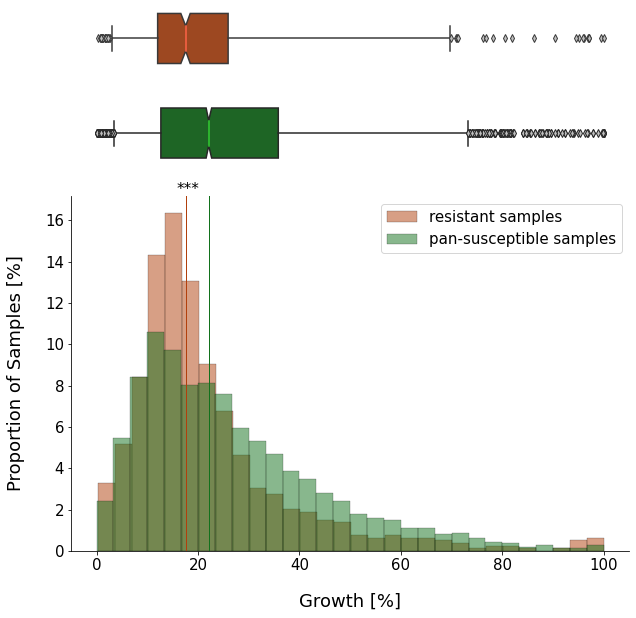

In [282]:
#set color palette
colors = palette("dark")

#load UNIQUEIDs of susceptible samples
pan_sus_samples = GENOMES[(GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS']))].index.to_series()

#make query for samples with resistance and only synonymous other mutations
res_gene_mutations = EFFECTS.GENE_MUTATION
query = res_gene_mutations.unique()

MUTATIONS['SYNONYMOUS'] = MUTATIONS['MUTATION'].apply(lambda x: x[0]==x[-1])
syn_mutations = MUTATIONS[MUTATIONS.SYNONYMOUS].GENE_MUTATION.unique()
query = numpy.append(query, syn_mutations)

MUTATIONS['QUERY'] = MUTATIONS.GENE_MUTATION.isin(query)
tmp = MUTATIONS.groupby(MUTATIONS.UNIQUEID).mean()
only_query = tmp[tmp.QUERY == 1].index.to_series()

#load UNIQUEIDs of resistant samples
only_res = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(res_gene_mutations.unique())) 
                     & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID

#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(only_res.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#calculate p-value
stat, p = mannwhitneyu(resistant, susceptible)
    
#save quantiles, median and confidence intervals
stats = []
sus_boot = my_bootstrap(susceptible)
stats.append(['susceptible', sus_boot[0], sus_boot[1][0], sus_boot[1][1], 
              p, round(numpy.mean(susceptible), 2), len(susceptible)])      #to do this for the mean, just use numpy.mean instead
res_boot = my_bootstrap(resistant)
stats.append(['any resistance', res_boot[0], res_boot[1][0], res_boot[1][1],
              p, round(numpy.mean(resistant), 2), len(resistant)])          #to do this for the mean, just use numpy.mean instead

#Plot histograms with boxplots
fig, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.85)})
fig.set_size_inches(10, 10)

sns.histplot(data = resistant, label="resistant samples", color = colors[1], **hist_args)
plt.axvline(res_boot[0], color = colors[1], linewidth = 1)

plt.text(x = res_boot[0]-1.8, y = 17.3, s='***', size = 15)

sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)
plt.axvline(sus_boot[0], color = colors[2], linewidth = 1)

sns.boxplot(resistant, ax = ax_box1, color = colors[1], medianprops={"color": "tomato"}, 
            usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)
sns.boxplot(susceptible, ax = ax_box2, color = colors[2], medianprops={"color": "LimeGreen"}, 
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]], **box_args)

#Despine plots
sns.despine(top = True, right=True, left = False, bottom = False, offset = False, trim = False)

axes = [ax_box1, ax_box2]
for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

# will need this for creating figures for poster:
# fig.savefig('poster_res_vs_sus.svg', format='svg', dpi=1200)

**Supplementary Figure S1(A-C)** Plot layout as in Figure 2, but the red bar plot represents a subset of RIF resistant samples that exhibit only the resistance mutation indicated in the legend and no other potentially interfering mutations.

100%|██████████| 113/113 [00:06<00:00, 17.59it/s]


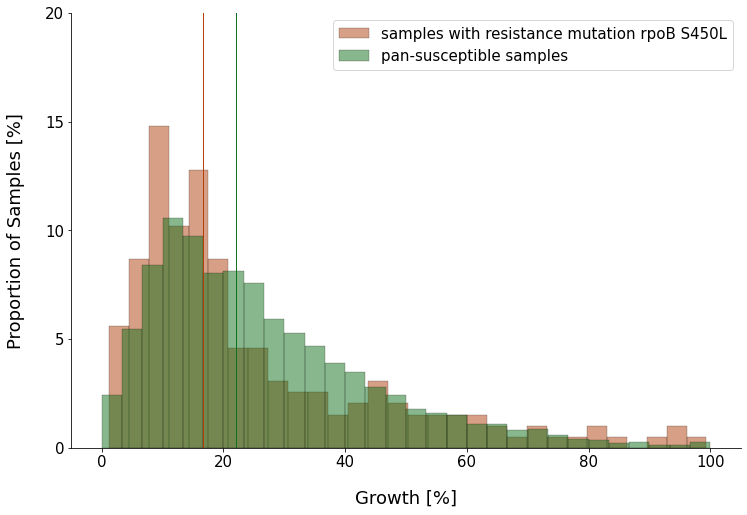

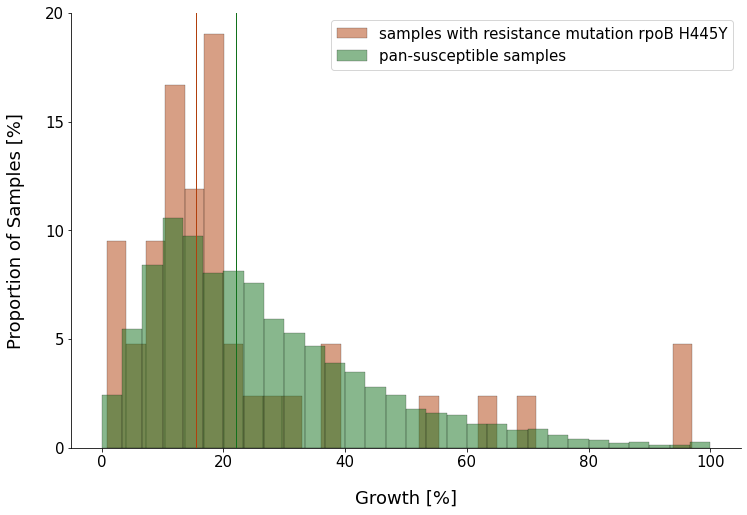

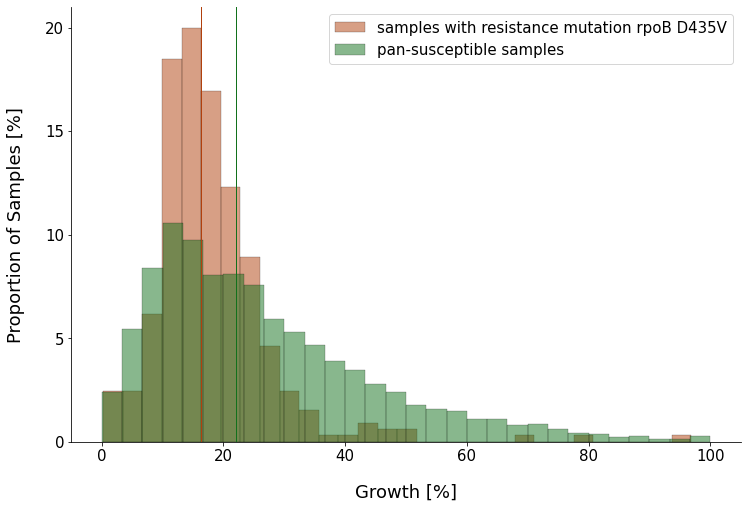

In [283]:
#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#fetch resistance mutations
res_gene_mutations = EFFECTS.GENE_MUTATION.unique()

#iterate through resistance mutations
for res in tqdm(res_gene_mutations):
    
    #query for samples with resistance and only synonymous other mutations
    spec_res = MUTATIONS[(MUTATIONS.GENE_MUTATION == res) & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID
    
    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(spec_res.values.tolist()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #set reasonable prevalence cut-off for resistance mutation
    if len(resistant) < 40:
        continue
    
    #calculate p-value
    stat, p = mannwhitneyu(resistant, susceptible)
    
    #plot growth distributions below p-value cut-off
    if p < (0.05):
        
        fig, ax = plt.subplots()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        fig.set_size_inches(12, 8)

        sns.histplot(data = resistant, bins = 30, alpha = 0.5, 
                     label="samples with resistance mutation " + res[0:4] + ' ' + res[5:], stat = "percent", 
                     color = colors[1], edgecolor='k', linewidth = 0.2)
        plt.axvline(resistant.median(), color = colors[1], linewidth = 1)
        
        sns.histplot(data = susceptible, bins = 30, alpha = 0.5, 
                     label="pan-susceptible samples", stat = "percent", 
                     color = colors[2], edgecolor='k', linewidth = 0.2)
        plt.axvline(susceptible.median(), color = colors[2], linewidth = 1)
        
        plt.xlabel("Growth [%]", size = 18, labelpad = 20)
        plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
        
        plt.xticks(fontsize = 15)
        plt.yticks(numpy.arange(0, 21, 5.0), fontsize = 15)
        
        plt.legend(loc = 'upper right', fontsize = 15)
        

**Figure 2(B)** Bar plot representation of Supplementary Figure 1

100%|██████████| 113/113 [00:06<00:00, 17.18it/s]


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

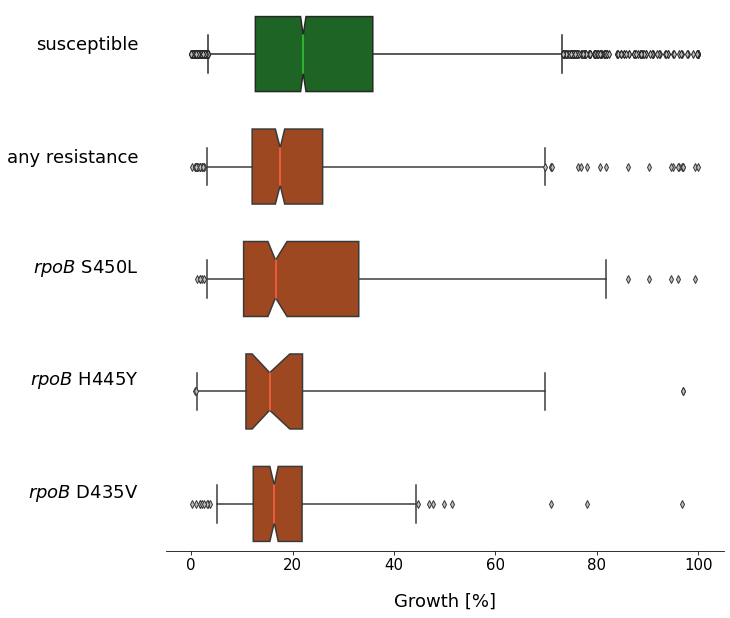

In [284]:
#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(only_res.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#load growth data for suscpetible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#fetch resistance mutations
res_gene_mutations = EFFECTS.GENE_MUTATION.unique()

fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_box5) = plt.subplots(5, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.15, 0.15)})

#plot figure
fig.set_size_inches(10, 10)

sus_boot = my_bootstrap(susceptible)
sns.boxplot(susceptible, ax = ax_box1, color = colors[2], medianprops={"color": "LimeGreen"},
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]], **box_args)
ax_box1.set_ylabel ('susceptible', fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')

res_boot = my_bootstrap(resistant)
sns.boxplot(resistant, ax = ax_box2, color = colors[1], medianprops={"color": "tomato"}, 
            usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)
ax_box2.set_ylabel ('any resistance', fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')

axes = [ax_box3, ax_box4, ax_box5]
i=0

for res in tqdm(res_gene_mutations):
    
    #query for samples with resistance and only synonymous other mutations
    spec_res = MUTATIONS[(MUTATIONS.GENE_MUTATION == res) & (MUTATIONS.UNIQUEID.isin(only_query))].UNIQUEID
    
    #load growth data for resistant UNIQUEIDs
    resistant = PLATES[(PLATES.UNIQUEID.isin(spec_res.values.tolist()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #set reasonable prevalence cut-off for resistance mutation
    if len(resistant) < 40:
        continue
    
    #calculate p-value
    stat, p = mannwhitneyu(resistant, susceptible)
    
    #plot growth distributions below p-value cut-off
    if p < (0.05):
        
        ax = axes[i]
        i = i+1

        res_boot = my_bootstrap(resistant)
        sns.boxplot(resistant, ax = ax, color = colors[1], medianprops={"color": "tomato"}, 
                    usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)
       
        ax.set_ylabel ('$\it{rpoB}$' + ' ' + res[5:], fontsize = 18, labelpad = 20, 
                       rotation=0, horizontalalignment='right')
        
        #save p-value and median + CIs
        stats.append([res[0:4] + ' ' + res[5:], res_boot[0], res_boot[1][0], res_boot[1][1], 
                      p, round(numpy.mean(resistant), 2), len(resistant)])
        
#Despine plots

axes = [ax_box1, ax_box2, ax_box3, ax_box4, ax_box5]

for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

#Respine bottom plot

sns.despine(ax = ax_box5, top = True, right=True, left = True, bottom = False, offset = False, trim = False)
ax_box5.tick_params(left = False, bottom = True) 

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)

**Table 1: Median growth of samples with different resistance mutations.**

Mann-Whitney p-value is calculated in reference to pan- susceptible sample growth and n indicates the sample size.

In [285]:
table = pandas.DataFrame(stats, columns = ['mutation','median growth [%]', 'CI low', 'CI high', 'p-value', 'mean growth [%]', 'n'], index = None)
table = table.drop(['mean growth [%]'], axis = 1)
print(table.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
      mutation &  median growth [\%] &  CI low &  CI high &      p-value &    n \\
\midrule
   susceptible &              22.10 &   21.60 &    22.69 & 2.953881e-12 & 5283 \\
any resistance &              17.57 &   16.61 &    18.46 & 2.953881e-12 &  795 \\
    rpoB S450L &              16.65 &   15.15 &    18.92 & 4.370956e-03 &  196 \\
    rpoB H445Y &              15.50 &   12.04 &    19.46 & 1.260896e-02 &   42 \\
    rpoB D435V &              16.40 &   15.53 &    17.18 & 3.920754e-14 &  325 \\
\bottomrule
\end{tabular}



**Table S2: Preliminary hit list of Numerical test for association of resistance with co-occuring mutations.**

In [286]:
hits = pandas.read_excel('hits_final.xlsx')

print(hits.to_latex(index = False))

\begin{tabular}{llrrrrrrr}
\toprule
resistant\_mutation &  other\_mutation &  p\_value &  None &  other &  resistant &  both &  n\_resistant &  n\_other \\
\midrule
        rpoB\_S450L &     rpoC\_P1040R &  0.00000 & 51081 &     32 &      13213 &   396 &        13609 &      428 \\
        rpoB\_S450L &      rpoC\_G332R &  0.00000 & 51108 &      5 &      13496 &   113 &        13609 &      118 \\
        rpoB\_S450L &      rpoC\_I491V &  0.00000 & 51094 &     19 &      12944 &   665 &        13609 &      684 \\
        rpoB\_S450L &      rpoC\_F452L &  0.00000 & 51110 &      3 &      13513 &    96 &        13609 &       99 \\
        rpoB\_S450L &      rpoC\_I491T &  0.00000 & 51103 &     10 &      13152 &   457 &        13609 &      467 \\
        rpoB\_S450L &      rpoC\_N698S &  0.00000 & 51111 &      2 &      13404 &   205 &        13609 &      207 \\
        rpoB\_S450L &      rpoC\_L516P &  0.00000 & 51110 &      3 &      13465 &   144 &        13609 &      147 \\
        rpoB\_S4

**Table S2: Hit list of Numerical test hits for association of resistance with co-occuring mutations after applying a filter for excluding synonymous mutations.**

In [287]:
#lineage_assoc = ['rpoC_A542A', 'rpoB_G876G', 'rpoA_G156G', 'rpoB_A1075A']
#hits = hits[~(hits.other_mutation.isin(lineage_assoc))]
hits = hits[~(hits.other_mutation.apply(lambda x: x[5]==x[-1]))]
hits = hits.drop(['n_other', 'n_resistant', 'p_value', 'None', 'resistant'], axis = 1)
hits = hits.sort_values('both', ascending = False)
print(hits.to_latex(index = False))

\begin{tabular}{llrr}
\toprule
resistant\_mutation &  other\_mutation &  other &  both \\
\midrule
        rpoB\_S450L &     rpoC\_E1092D &   2012 &  1989 \\
        rpoB\_S450L &      rpoC\_V483G &     37 &  1206 \\
        rpoB\_S450L &      rpoC\_I491V &     19 &   665 \\
        rpoB\_S450L &      rpoC\_V483A &     33 &   586 \\
        rpoB\_S450L &      rpoC\_I491T &     10 &   457 \\
        rpoB\_S450L &     rpoC\_P1040R &     32 &   396 \\
        rpoB\_S450L &      rpoC\_F452S &      2 &   345 \\
        rpoB\_S450L &      rpoB\_E761D &      0 &   304 \\
        rpoB\_S450L &      rpoB\_L731P &      1 &   226 \\
        rpoB\_S450L &      rpoC\_N698S &      2 &   205 \\
        rpoB\_S450L &      rpoC\_D485Y &      8 &   194 \\
        rpoB\_S450L &      rpoC\_V517L &      1 &   184 \\
        rpoB\_S450L &      rpoC\_G332S &     16 &   179 \\
        rpoB\_S450L &     rpoC\_V1252L &      3 &   175 \\
        rpoB\_S450L &      rpoA\_T187A &      3 &   171 \\
        rpoB\_S4

**Figure 3: Growth and lineage distributions of M. tuberculosis samples that are pan-susceptible, rifampicin (RIF) resistant and resistant with compensatory mutations (CMs)**

**3(A)** Distribution of growth in percent as measured in the CRyPTIC project, plotted against the proportion of samples that display this amount of growth. This plot represents the overall data set.

resistant to susceptible: 6.222710518471159e-14 p-value to res 1.2278833183557639e-61 p-value to sus 1.2013198859408316e-30


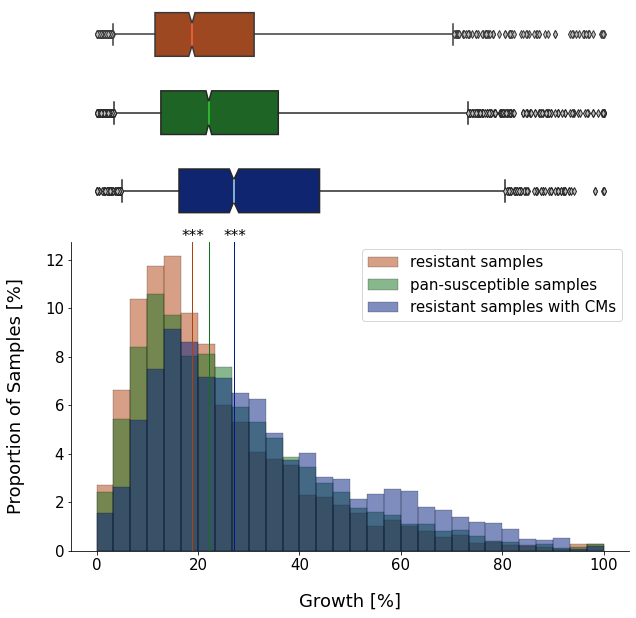

In [289]:
#set color palette
colors = palette("dark")

#load UNIQUEIDs of resistant samples with CMs
res_CM_samples = []

for i, name in enumerate(hits.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == name)].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))].UNIQUEID.unique()
    res_CM_samples.append(hit_samples_local)

res_CM_samples = numpy.concatenate(res_CM_samples)
res_CM_samples = pandas.Series(res_CM_samples)

#load UNIQUEIDs of resistant samples without CMs
res_samples = EFFECTS[~(EFFECTS.UNIQUEID.isin(res_CM_samples))].UNIQUEID.values.tolist()
res_samples = pandas.Series(res_samples)

#load growth data for susceptible UNIQUEIDs
susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#load growth data for resistant UNIQUEIDs
resistant = PLATES[(PLATES.UNIQUEID.isin(res_samples.values.tolist()))].IM_POS_AVERAGE
resistant.dropna(inplace = True)

#load growth data for resistant with CMs UNIQUEIDs
resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.values.tolist()))].IM_POS_AVERAGE
resistant_CM.dropna(inplace = True)

#calculate p-values
stat1, p1 = mannwhitneyu(resistant, susceptible)
stat2, p2 = mannwhitneyu(resistant, resistant_CM)
stat3, p3 = mannwhitneyu(resistant_CM, susceptible)

#save p-value and median
stats = []
sus_boot = my_bootstrap(susceptible)
stats.append(['susceptible (sus)', sus_boot[0], sus_boot[1][0], sus_boot[1][1], '', '', 
              round(numpy.mean(susceptible), 2), len(susceptible)])
res_boot = my_bootstrap(resistant)
stats.append(['resistant and no CMs (res)', res_boot[0], res_boot[1][0], res_boot[1][1], '', '', 
              round(numpy.mean(resistant), 2), len(resistant)], )
            #round(bootstrap((resistant,), numpy.median, confidence_level = 0.95).confidence_interval.low, 2), 
            #round(bootstrap((resistant,), numpy.median, confidence_level = 0.95).confidence_interval.high, 2)
resCM_boot = my_bootstrap(resistant_CM)
stats.append(['resistant and any CMs', resCM_boot[0], resCM_boot[1][0], resCM_boot[1][1], 
              str(p2), str(p3), round(numpy.mean(resistant_CM), 2), len(resistant_CM)])

print('resistant to susceptible:',p1, 'p-value to res', p2, 'p-value to sus', p3)

#Plot histograms with boxplots

fig, (ax_box1, ax_box2, ax_box3, ax_hist) = plt.subplots(4, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.85)})

fig.set_size_inches(10, 10)

sns.histplot(data = resistant, label="resistant samples", color = colors[1], **hist_args)
plt.axvline(resistant.median(), color = colors[1], linewidth = 1)

plt.text(x = resistant.median()-2, y = 12.8, s='***', size = 15) #TODO

sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)
plt.axvline(susceptible.median(), color = colors[2], linewidth = 1)

sns.histplot(data = resistant_CM, label="resistant samples with CMs", color = colors[0], **hist_args)
plt.axvline(resistant_CM.median(), color = colors[0], linewidth = 1)

plt.text(x = resistant_CM.median()-2, y = 12.8, s='***', size = 15) #TODO
    
sns.boxplot(resistant, ax = ax_box1, color = colors[1], medianprops={"color": "tomato"}, 
            usermedians = [res_boot[0]], conf_intervals = [res_boot[1]], **box_args)  
sns.boxplot(susceptible, ax = ax_box2, color = colors[2], medianprops={"color": "LimeGreen"}, 
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]],**box_args)
sns.boxplot(resistant_CM, ax = ax_box3, color = colors[0], medianprops={"color": "LightBlue"}, 
            usermedians = [resCM_boot[0]], conf_intervals = [resCM_boot[1]],**box_args)

#Despine plots
sns.despine(top = True, right=True, left = False, bottom = False, offset = False, trim = False)

axes = [ax_box1, ax_box2, ax_box3]
for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

# for creating poster figures:
# fig.savefig('poster_res_vs_sus_vs_CM.svg', format='svg', dpi=1200)

**Supplementary Figure 2: Plot growth distribution of all pan-susceptible samples against those with a specific resistance mutations and those with this resistance mutations and a specific CM incl. p-value calculation**

Histogram representation

100%|██████████| 25/25 [00:01<00:00, 19.46it/s]


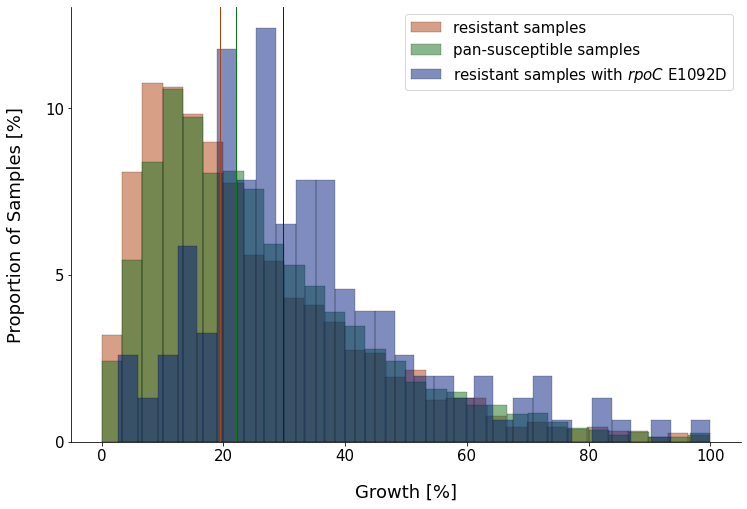

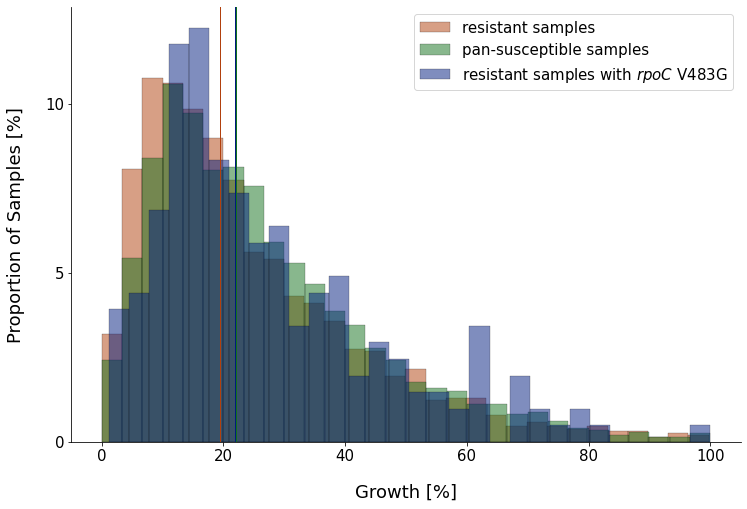

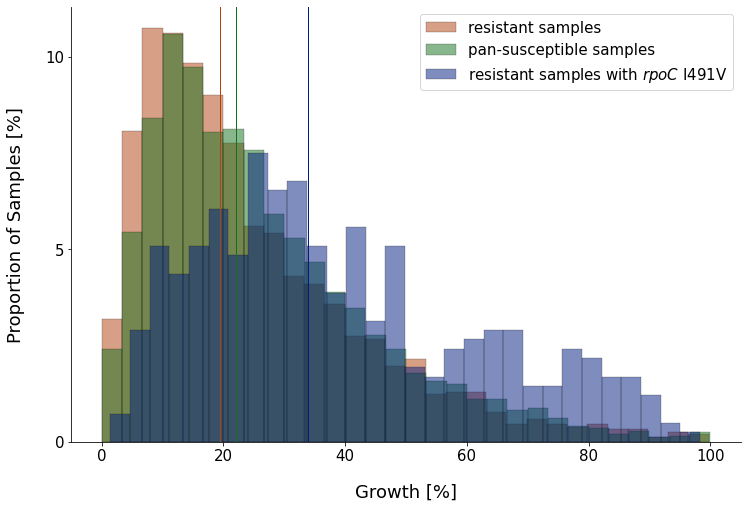

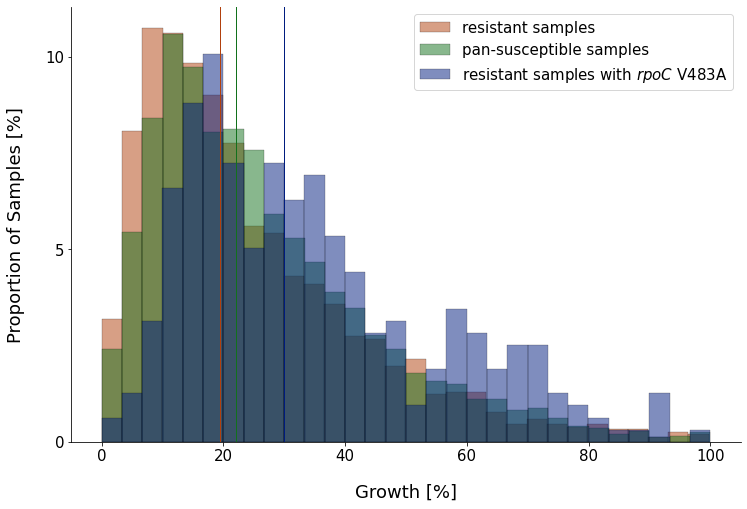

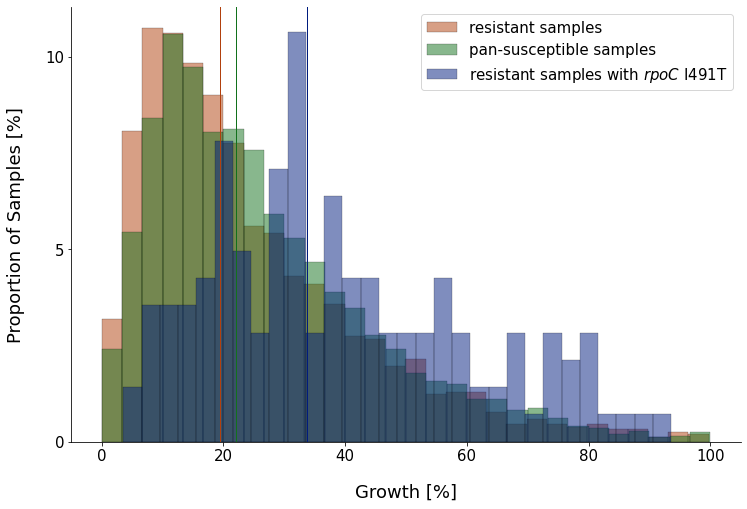

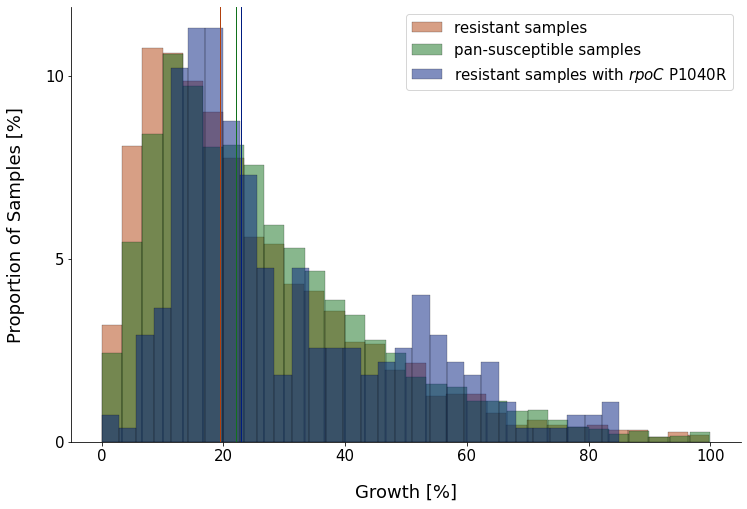

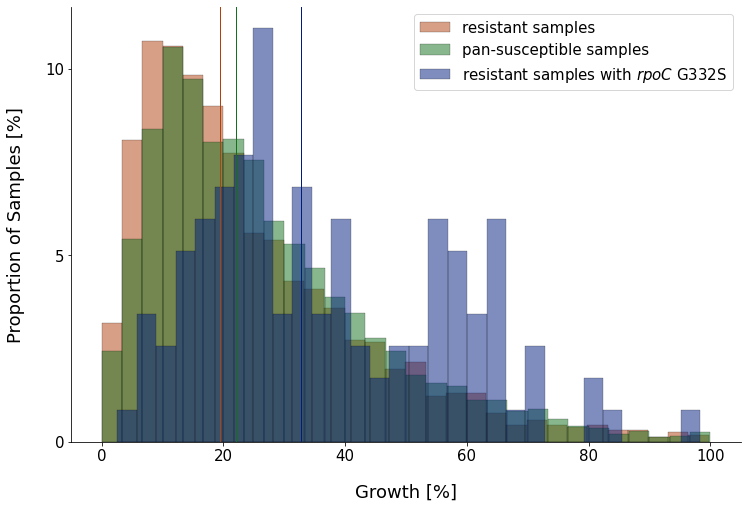

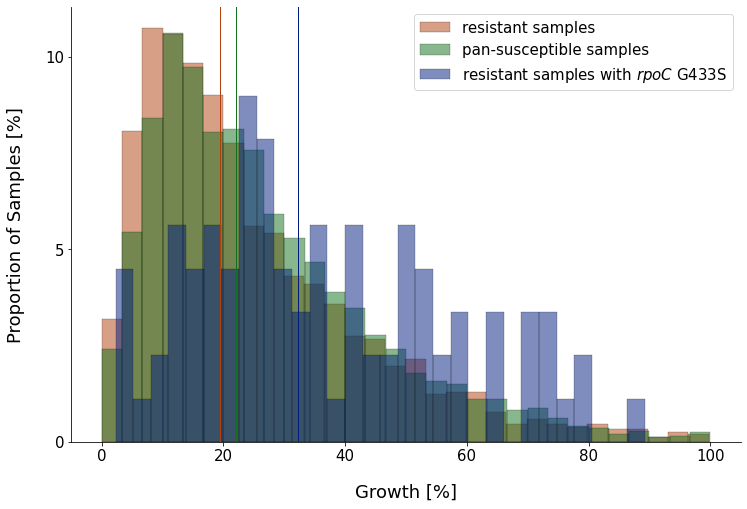

In [291]:
#set color palette
colors = palette("dark")

#make list of samples with resistance mutations and CMs
concat_samples = []

for i, name in enumerate(hits.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == hits.resistant_mutation.unique()[i])].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))].UNIQUEID.unique()
    
    concat_samples.append(hit_samples_local)

concat_samples = numpy.concatenate(concat_samples)
concat_samples = pandas.DataFrame(concat_samples,columns=['UNIQUEID'])

#make list of observed combinations of resistance and CM
hit_samples = []
name = []

for i, mut in enumerate(hits.resistant_mutation.unique()):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == hits.resistant_mutation.unique()[i])].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))]
    name_local = mut + '_' + hit_samples_local.GENE_MUTATION
    
    name.append(name_local)
    hit_samples.append(hit_samples_local.UNIQUEID)

hit_samples = numpy.concatenate(hit_samples)
name = numpy.concatenate(name)
hit_samples = pandas.DataFrame(hit_samples,name,columns = ['UNIQUEID'])

#filter out all combinations with prevalence of <100 (won't make for a representable plot)
hit_samples = hit_samples.reset_index()
hit_samples.rename(columns = {'index':'mutations'}, inplace = True) 

prevalence = hit_samples.mutations.value_counts()>100
combinations = prevalence[prevalence].index.tolist()

hit_samples = hit_samples.set_index('mutations')

susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

for i, combination in enumerate(tqdm(combinations)):
    res_CM_samples = hit_samples.loc[combination]
    
    #only include resistant samples with specific resistance mutation in combination
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist())) 
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist())))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #set reasonable prevalence cutoff
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-values
    stat, p1 = mannwhitneyu(resistant, susceptible)
    stat, p2 = mannwhitneyu(resistant, resistant_CM)
    stat, p3 = mannwhitneyu(resistant_CM, susceptible)
    
    #plot growth distributions below p-value cut-off
    if p2 < (0.01): 

        fig, ax = plt.subplots()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
        fig.set_size_inches(12, 8)

        sns.histplot(data = resistant, label="resistant samples", color = colors[1], **hist_args)
        plt.axvline(resistant.median(), color = colors[1], linewidth = 1)
        
        sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)
        plt.axvline(susceptible.median(), color = colors[2], linewidth = 1)

        sns.histplot(data = resistant_CM, label="resistant samples with " + '$\it{rpoC}$' + ' ' + combination[16:], color = colors[0], **hist_args)
        plt.axvline(resistant_CM.median(), color = colors[0], linewidth = 1)
        
        plt.xlabel("Growth [%]", size = 18, labelpad = 20)
        plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
        
        plt.xticks(fontsize = 15)
        plt.yticks(numpy.arange(0, 13, 5.0), fontsize = 15)
        
        plt.legend(loc = 'upper right', fontsize = 15)
        #plt.title(combination, fontsize = 15, pad = 15)
        

**Figure 3(B) Boxplot representation of Supplementary Figure 2**

100%|██████████| 25/25 [00:01<00:00, 15.35it/s]


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

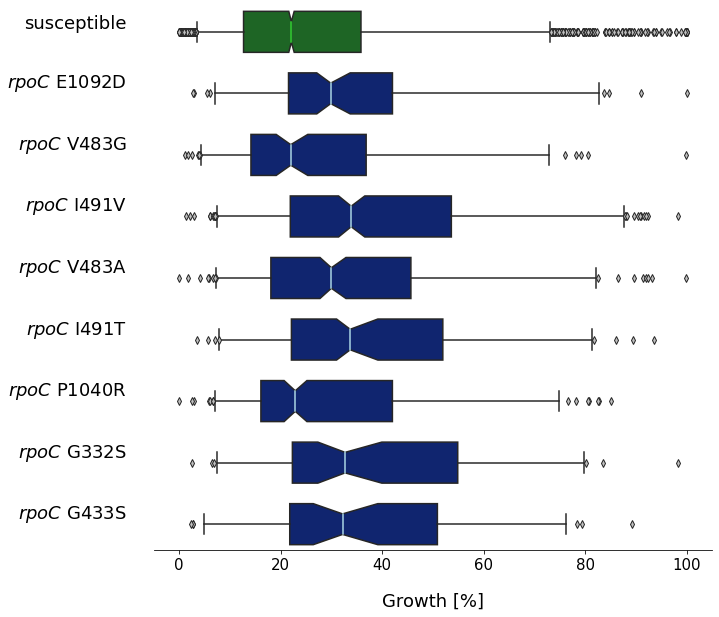

In [293]:
#set color palette
colors = palette("dark")

#make list of samples with resistance mutations and CMs
concat_samples = []

for i, name in enumerate(tqdm(hits.resistant_mutation.unique())):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == hits.resistant_mutation.unique()[i])].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))].UNIQUEID.unique()
    
    concat_samples.append(hit_samples_local)

concat_samples = numpy.concatenate(concat_samples)
concat_samples = pandas.DataFrame(concat_samples,columns=['UNIQUEID'])

#make list of observed combinations of resistance and CM
hit_samples = []
name = []

for i, mut in enumerate(tqdm(hits.resistant_mutation.unique())):
    resistance = MUTATIONS[(MUTATIONS.GENE_MUTATION == hits.resistant_mutation.unique()[i])].UNIQUEID
    hit_samples_local = MUTATIONS[(MUTATIONS.GENE_MUTATION.isin(hits.other_mutation.values.tolist())) 
                                  & (MUTATIONS.UNIQUEID.isin(resistance.tolist()))]
    name_local = mut + '_' + hit_samples_local.GENE_MUTATION
    
    name.append(name_local)
    hit_samples.append(hit_samples_local.UNIQUEID)

hit_samples = numpy.concatenate(hit_samples)
name = numpy.concatenate(name)
hit_samples = pandas.DataFrame(hit_samples,name,columns = ['UNIQUEID'])

#filter out all combinations with prevalence of <100 (won't make for a representable plot)
hit_samples = hit_samples.reset_index()
hit_samples.rename(columns = {'index':'mutations'}, inplace = True) 

prevalence = hit_samples.mutations.value_counts()>100
combinations = prevalence[prevalence].index.tolist()

hit_samples = hit_samples.set_index('mutations')

susceptible = PLATES[(PLATES.UNIQUEID.isin(pan_sus_samples.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7, ax_box8, ax_box9) = plt.subplots(9, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15)})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.set_size_inches(10, 10)

sus_boot = my_bootstrap(susceptible)
sns.boxplot(susceptible, ax = ax_box1, color = colors[2], medianprops={"color": "LimeGreen"}, 
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]], **box_args)
ax_box1.set_ylabel ('susceptible', fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')

axes = [ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7, ax_box8, ax_box9]
j=0

for i, combination in enumerate(tqdm(combinations)):
    res_CM_samples = hit_samples.loc[combination]
    
    #only include resistant samples with specific resistance mutation in combination
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist())) 
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist())))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #set reasonable prevalence cutoff
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-values
    stat, p1 = mannwhitneyu(resistant, susceptible)
    stat, p2 = mannwhitneyu(resistant, resistant_CM)
    stat, p3 = mannwhitneyu(resistant_CM, susceptible)
    
    #plot growth distributions below p-value cut-off
    if p2 < (0.01): 
        
        ax = axes[j]
        j = j+1
        
        resCM_boot = my_bootstrap(resistant_CM)
        sns.boxplot(resistant_CM, ax = ax, color = colors[0], medianprops={"color": "LightBlue"}, 
                    usermedians = [resCM_boot[0]], conf_intervals = [resCM_boot[1]], **box_args)

        ax.set_ylabel ('$\it{rpoC}$' + ' ' + combination[16:], fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')
        
        stats.append([combination[11:15] + ' ' + combination[16:], resCM_boot[0], resCM_boot[1][0], resCM_boot[1][1],
              str(p2), str(p3), round(numpy.mean(resistant_CM), 2), len(resistant_CM)])

#Despine plots
axes = [ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7, ax_box8, ax_box9]

for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

#Respine bottom plot
sns.despine(ax = ax_box9, top = True, right=True, left = True, bottom = False, offset = False, trim = False)
ax_box9.tick_params(left = False, bottom = True) 

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)
# use this to save high quality svg for poster
# fig.savefig('poster_single_CMs_vs_sus.svg', format='svg', dpi=1200, bbox_inches='tight')

**Supplementary Table S3: Median growth and median confidence intervals of samples with different compensatory mutations compared to susceptibles and samples with only resistance**

In [294]:
table = pandas.DataFrame(stats, columns = ['mutation','median growth [%]', 'CI low', 'CI high', 'p-value to res', 'p-value to sus', 'mean growth [%]', 'n'], index = None)
table = table.drop(['mean growth [%]', 'p-value to res', 'p-value to sus'], axis = 1)
print(table.to_latex(index = False))

\begin{tabular}{lrrrr}
\toprule
                  mutation &  median growth [\%] &  CI low &  CI high &    n \\
\midrule
         susceptible (sus) &              22.10 &   21.57 &    22.69 & 5283 \\
resistant and no CMs (res) &              18.83 &   18.17 &    19.41 & 3153 \\
     resistant and any CMs &              27.04 &   26.17 &    28.04 & 2383 \\
               rpoC E1092D &              29.86 &   27.11 &    33.70 &  153 \\
                rpoC V483G &              21.98 &   18.96 &    25.34 &  204 \\
                rpoC I491V &              33.89 &   31.41 &    36.56 &  413 \\
                rpoC V483A &              29.99 &   27.72 &    32.87 &  318 \\
                rpoC I491T &              33.70 &   30.98 &    39.15 &  141 \\
               rpoC P1040R &              22.87 &   20.58 &    25.13 &  274 \\
                rpoC G332S &              32.69 &   27.33 &    39.93 &  117 \\
                rpoC G433S &              32.20 &   26.42 &    39.14 &   89 \\
          

**Figure 4(A): Distribution of TB lineages overall and within plotted samples with resistance or with CMs**

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

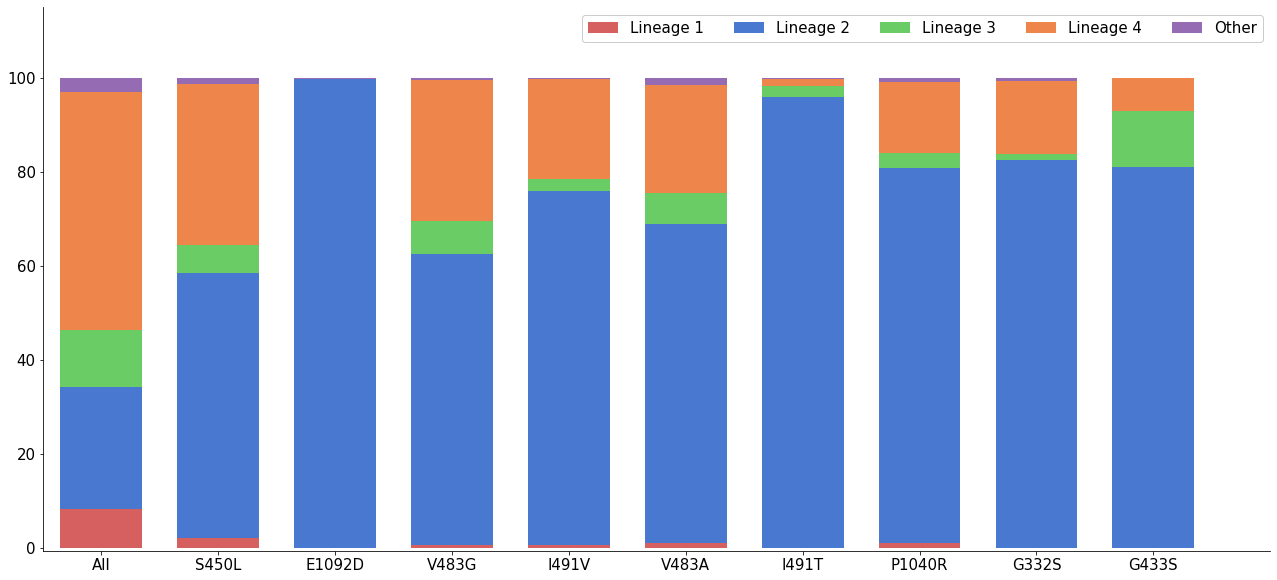

In [295]:
#set color palette
colors = palette("muted")

#concatenate all lineages with low prevalence (all except 1-4)
query = ['Mixed', 'Unknown', 'Lineage Bovis', 'Lineage 5', 'Lineage 6', 'Lineage 7', 'Lineage Caprae']
query

GENOMES['cut_lineages'] = GENOMES.MYKROBE_LINEAGE_NAME_1
GENOMES.cut_lineages.loc[GENOMES.MYKROBE_LINEAGE_NAME_1.isin(query)] = 'Other'
GENOMES[(GENOMES.cut_lineages == 'Other')]

labels = ['Overall dataset', 'rpoB S450L']

lineages = GENOMES.cut_lineages.value_counts()
lineages = (lineages/lineages.sum()) * 100
lineages = lineages.sort_index()
lineages = pandas.DataFrame({'Type': lineages.index,
                            'All': lineages.values})
lineages = lineages.transpose()
header_row = lineages.iloc[0]
lineages = pandas.DataFrame(lineages.values[1:], columns=header_row)
lineages.index = ['All']
lineages

resistant_mutation_samples = MUTATIONS[(MUTATIONS.GENE_MUTATION == 'rpoB_S450L')].UNIQUEID
lineages_res = GENOMES[(GENOMES.index.isin(resistant_mutation_samples))].cut_lineages.value_counts()
lineages_res = (lineages_res/lineages_res.sum()) * 100
lineages_res = lineages_res.sort_index()
lineages_res = pandas.DataFrame({'Type': lineages_res.index,
                            'All': lineages_res.values})
lineages_res = lineages_res.transpose()
header_row = lineages_res.iloc[0]
lineages_res = pandas.DataFrame(lineages_res.values[1:], columns = header_row)
lineages_res.index = ['S450L']
lineages_res

result = pandas.concat([lineages, lineages_res], axis=0, join = 'outer')

for i, combination in enumerate(combinations):
    res_CM_samples = hit_samples.loc[combination]
    lineages = GENOMES[(GENOMES.index.isin(res_CM_samples.UNIQUEID))].cut_lineages.value_counts()
    
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist()))
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist())))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #set reasonable prevalence cutoff
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-value
    stat, p2 = mannwhitneyu(resistant, resistant_CM)
    
    #plot growth distributions below p-value cut-off
    if p2 < (0.01):
        lineages = (lineages/lineages.sum()) * 100
        lineages = lineages.sort_index()
        lineages = pandas.DataFrame({'Type': lineages.index,
                                    'All': lineages.values})
        lineages = lineages.transpose()
        header_row = lineages.iloc[0]
        lineages = pandas.DataFrame(lineages.values[1:], columns=header_row)
        lineages.index = [combination[16:]]

        result = pandas.concat([result, lineages], axis=0, join = 'outer')

result = result.reset_index()
result = result.fillna(0)

fig, ax = plt.subplots(1, figsize=(22, 10))

x = numpy.array(result['index'])
y1 = numpy.array(result['Lineage 1'])
y2 = numpy.array(result['Lineage 2'])
y3 = numpy.array(result['Lineage 3'])
y4 = numpy.array(result['Lineage 4'])
y5 = numpy.array(result['Other'])
plt.bar(x, y1, color = colors[3], width = 0.7)
plt.bar(x, y2, bottom=y1, color = colors[0], width = 0.7)
plt.bar(x, y3, bottom=y1+y2, color = colors[2], width = 0.7)
plt.bar(x, y4, bottom=y1+y2+y3, color = colors[1], width = 0.7)
plt.bar(x, y5, bottom=y1+y2+y3+y4, color = colors[4], width = 0.7)

plt.ylim(-0.5, 115)
plt.xlim(-0.5, 10)

plt.legend(['Lineage 1', 'Lineage 2', 'Lineage 3', 'Lineage 4', 'Other'], loc='upper right', ncol = 5, fontsize = 15, framealpha=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize = 15)

plt.yticks(fontsize = 15)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

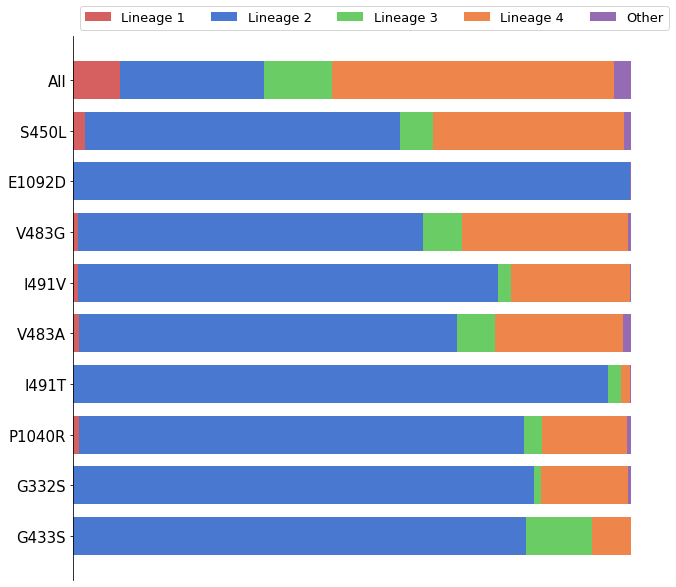

In [296]:
#set color palette
colors = palette("muted")

#concatenate all lineages with low prevalence (all except 1-4)
query = ['Mixed', 'Unknown', 'Lineage Bovis', 'Lineage 5', 'Lineage 6', 'Lineage 7', 'Lineage Caprae']
query

GENOMES['cut_lineages'] = GENOMES.MYKROBE_LINEAGE_NAME_1
GENOMES.cut_lineages.loc[GENOMES.MYKROBE_LINEAGE_NAME_1.isin(query)] = 'Other'
GENOMES[(GENOMES.cut_lineages == 'Other')]

labels = ['Overall dataset', 'rpoB S450L']

lineages = GENOMES.cut_lineages.value_counts()
lineages = (lineages/lineages.sum()) * 100
lineages = lineages.sort_index()
lineages = pandas.DataFrame({'Type': lineages.index,
                            'All': lineages.values})
lineages = lineages.transpose()
header_row = lineages.iloc[0]
lineages = pandas.DataFrame(lineages.values[1:], columns=header_row)
lineages.index = ['All']
lineages

resistant_mutation_samples = MUTATIONS[(MUTATIONS.GENE_MUTATION == 'rpoB_S450L')].UNIQUEID
lineages_res = GENOMES[(GENOMES.index.isin(resistant_mutation_samples))].cut_lineages.value_counts()
lineages_res = (lineages_res/lineages_res.sum()) * 100
lineages_res = lineages_res.sort_index()
lineages_res = pandas.DataFrame({'Type': lineages_res.index,
                            'All': lineages_res.values})
lineages_res = lineages_res.transpose()
header_row = lineages_res.iloc[0]
lineages_res = pandas.DataFrame(lineages_res.values[1:], columns = header_row)
lineages_res.index = ['S450L']
lineages_res

result = pandas.concat([lineages, lineages_res], axis=0, join = 'outer')

for i, combination in enumerate(combinations):
    res_CM_samples = hit_samples.loc[combination]
    lineages = GENOMES[(GENOMES.index.isin(res_CM_samples.UNIQUEID))].cut_lineages.value_counts()
    
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist()))
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist())))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #set reasonable prevalence cutoff
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-value
    stat, p2 = mannwhitneyu(resistant, resistant_CM)
    
    #plot growth distributions below p-value cut-off
    if p2 < (0.01):
        lineages = (lineages/lineages.sum()) * 100
        lineages = lineages.sort_index()
        lineages = pandas.DataFrame({'Type': lineages.index,
                                    'All': lineages.values})
        lineages = lineages.transpose()
        header_row = lineages.iloc[0]
        lineages = pandas.DataFrame(lineages.values[1:], columns=header_row)
        lineages.index = [combination[16:]]

        result = pandas.concat([result, lineages], axis=0, join = 'outer')

result = result.reset_index()
result = result.fillna(0)

category_names = list(result.columns.values[1:])

labels = list(result['index'])
result = result.drop(['index'], axis = 1)
data = numpy.array(list(result.values))
data_cum = data.cumsum(axis=1)
category_colors = [colors[3], colors[0], colors[2], colors[1], colors[4]]

fig, ax = plt.subplots(figsize=(10, 10))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, numpy.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.75,
                    label=colname, color=color)

    r, g, b = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    #ax.bar_label(rects, label_type='center', color = text_color, size = 15)

ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
            loc='lower left', fontsize = 13)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
plt.yticks(fontsize = 15)

# use this to save high quality svg for poster
# fig.savefig('poster_lineages_prevalence.svg', format='svg', dpi=1200)

**Figure 4(B): Analysis of Lineage growth distributions**

Histogram with boxplot representation for lineage growth

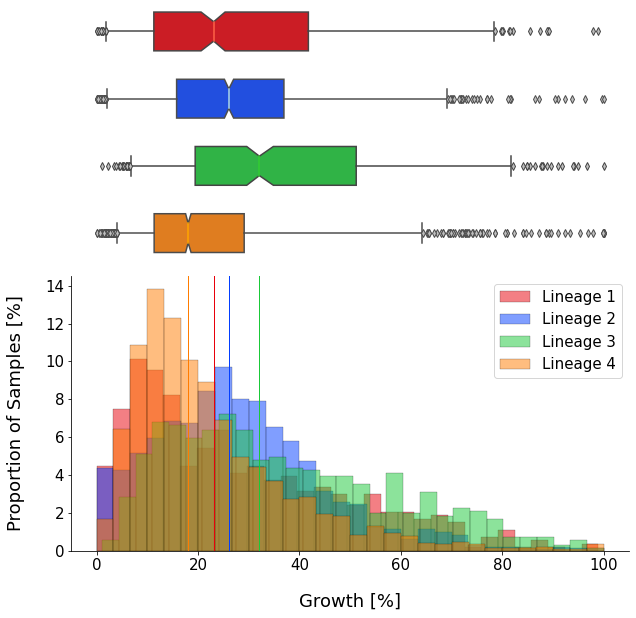

In [297]:
#set color palette
colors = palette("bright")

condition = GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS'])

#load growth data for lineages
lineage1 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 1')].index.to_series()
data1 = PLATES[(PLATES.UNIQUEID.isin(lineage1.values.tolist()))].IM_POS_AVERAGE
data1.dropna(inplace = True)

lineage2 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 2')].index.to_series()
data2 = PLATES[(PLATES.UNIQUEID.isin(lineage2.values.tolist()))].IM_POS_AVERAGE
data2.dropna(inplace = True)

lineage3 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 3')].index.to_series()
data3 = PLATES[(PLATES.UNIQUEID.isin(lineage3.values.tolist()))].IM_POS_AVERAGE
data3.dropna(inplace = True)

lineage4 = GENOMES[(condition) & (GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 4')].index.to_series()
data4 = PLATES[(PLATES.UNIQUEID.isin(lineage4.values.tolist()))].IM_POS_AVERAGE
data4.dropna(inplace = True)

#calculate p-values
stat1, p1 = mannwhitneyu(data1, data2)
stat2, p2 = mannwhitneyu(data1, data3)
stat3, p3 = mannwhitneyu(data1, data4)
stat4, p4 = mannwhitneyu(data2, data3)
stat5, p5 = mannwhitneyu(data2, data4)
stat6, p6 = mannwhitneyu(data3, data4)

#save p-value and median
stats = []
lin1_boot = my_bootstrap(data1)
stats.append(['Lineage 1', lin1_boot[0], lin1_boot[1][0], lin1_boot[1][1], len(data1)])
lin2_boot = my_bootstrap(data2)
stats.append(['Lineage 2', lin2_boot[0], lin2_boot[1][0], lin2_boot[1][1], len(data2)])
lin3_boot = my_bootstrap(data3)
stats.append(['Lineage 3', lin3_boot[0], lin3_boot[1][0], lin3_boot[1][1], len(data3)])
lin4_boot = my_bootstrap(data4)
stats.append(['Lineage 4', lin4_boot[0], lin4_boot[1][0], lin4_boot[1][1], len(data4)])

#Plot histograms with boxplots

fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_hist) = plt.subplots(5, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.15, 0.85)})

fig.set_size_inches(10, 10)

sns.histplot(data = data1, label="Lineage 1", color = colors[3], **hist_args)
plt.axvline(data1.median(), color = colors[3], linewidth = 1)

sns.histplot(data = data2, label="Lineage 2", color = colors[0], **hist_args)
plt.axvline(data2.median(), color = colors[0], linewidth = 1)

sns.histplot(data = data3, label="Lineage 3", color = colors[2], **hist_args)
plt.axvline(data3.median(), color = colors[2], linewidth = 1)

sns.histplot(data = data4, label="Lineage 4", color = colors[1], **hist_args)
plt.axvline(data4.median(), color = colors[1], linewidth = 1)

sns.boxplot(data1, ax = ax_box1, color = colors[3], medianprops={"color": "tomato"},
            usermedians = [lin1_boot[0]], conf_intervals = [lin1_boot[1]],**box_args)   
sns.boxplot(data2, ax = ax_box2, color = colors[0], medianprops={"color": "LightBlue"},
            usermedians = [lin2_boot[0]], conf_intervals = [lin2_boot[1]], **box_args)  
sns.boxplot(data3, ax = ax_box3, color = colors[2], medianprops={"color": "LimeGreen"}, 
            usermedians = [lin3_boot[0]], conf_intervals = [lin3_boot[1]],**box_args)
sns.boxplot(data4, ax = ax_box4, color = colors[1], medianprops={"color": "Orange"},
            usermedians = [lin4_boot[0]], conf_intervals = [lin4_boot[1]],**box_args)

#Despine plots
sns.despine(top = True, right=True, left = False, bottom = False, offset = False, trim = False)

axes = [ax_box1, ax_box2, ax_box3, ax_box4]
for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)
plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

**Supplementary Table S4: Median growth and median confidence intervals of growth for Lineages 1-4**

In [298]:
table = pandas.DataFrame(stats, columns = ['Lineage', 'median growth [%]', 'CI low', 'CI high', 'n'], index = None)

print(table.to_latex(index = False))

\begin{tabular}{lrrrr}
\toprule
  Lineage &  median growth [\%] &  CI low &  CI high &    n \\
\midrule
Lineage 1 &              23.09 &   20.60 &    25.33 &  534 \\
Lineage 2 &              26.08 &   25.20 &    27.02 & 1331 \\
Lineage 3 &              32.09 &   29.60 &    34.85 &  706 \\
Lineage 4 &              18.06 &   17.55 &    18.63 & 2656 \\
\bottomrule
\end{tabular}



**Supplementary Figure S3: Plot only susceptibles within lineage 2 against resistance + CM in lineage 2 for all remaining CMs to find out if better growth than wildtype is only due to lineage 2 prevalence in resistant samples**

histogram representation

100%|██████████| 25/25 [00:01<00:00, 15.68it/s]


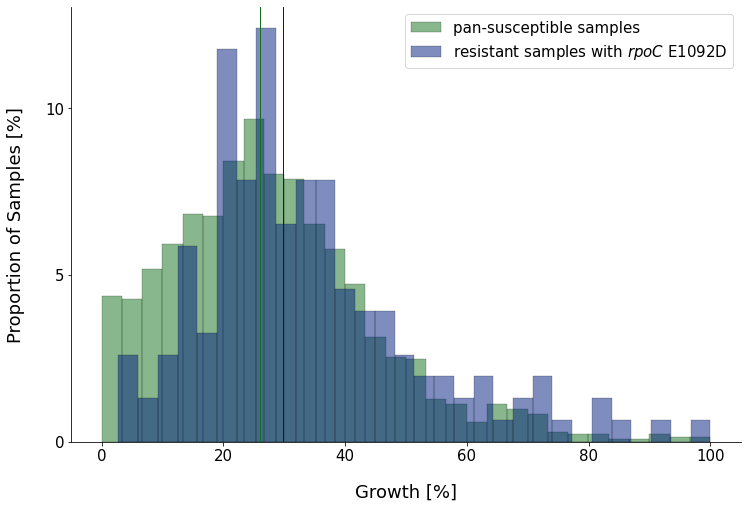

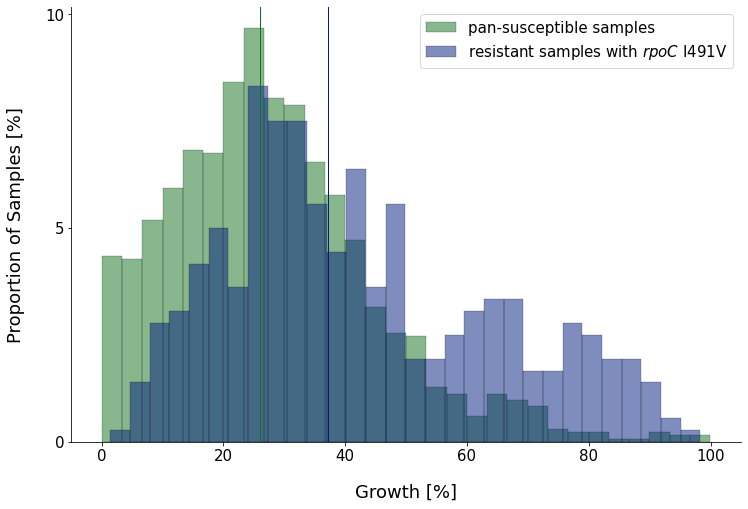

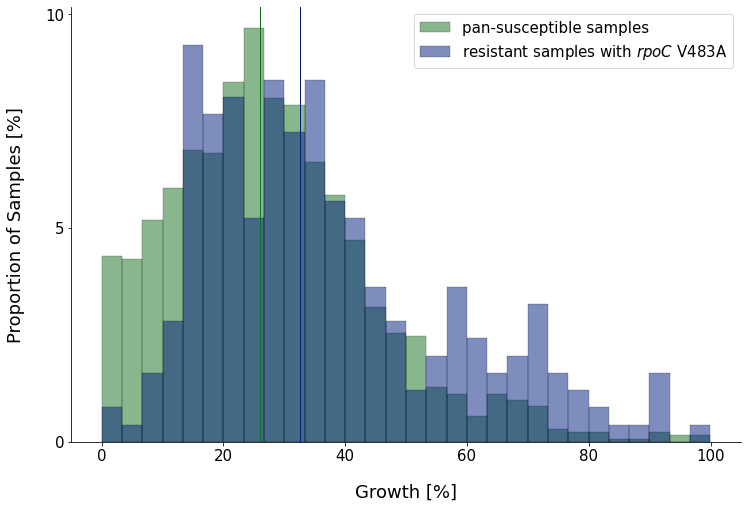

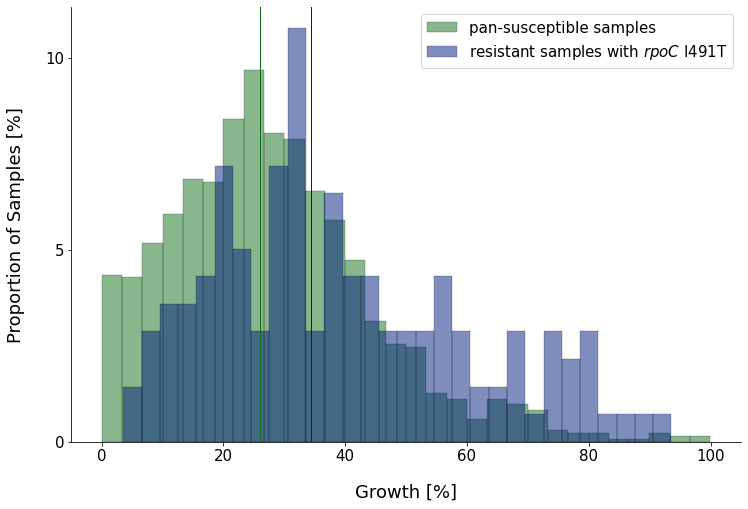

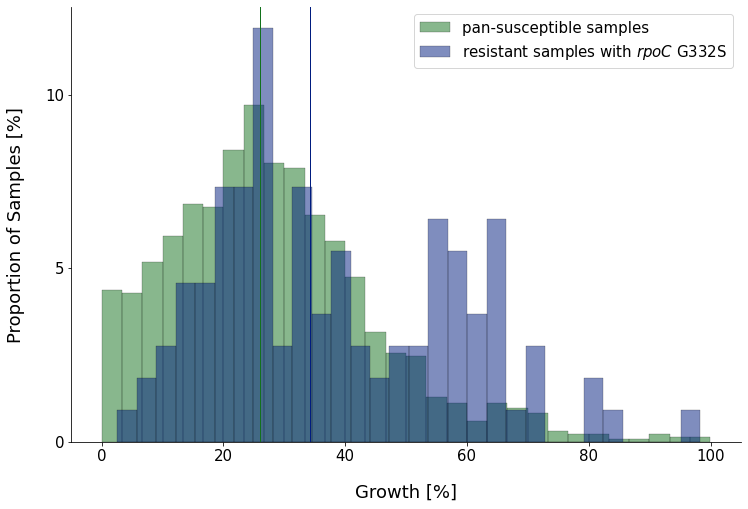

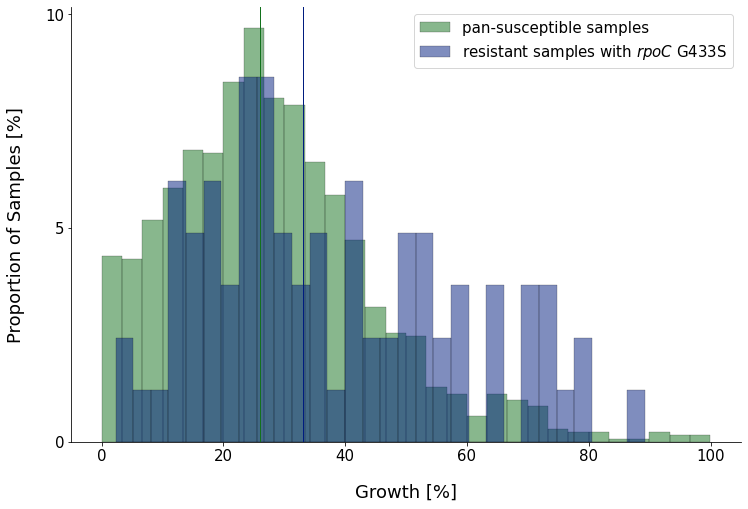

In [299]:
#set color palette
colors = palette("dark")

#load growth data for susceptibles in lineage 2
condition1 = GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS'])
condition2 = GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 2'

lineage2 = GENOMES[(condition1) & (condition2)].index.to_series()
susceptible = PLATES[(PLATES.UNIQUEID.isin(lineage2.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#save p-values and medians
p_values_medians = []
p_values_medians.append(['susceptible (sus)', numpy.mean(susceptible), ' ', ' ', len(susceptible)])

for i, combination in enumerate(tqdm(combinations)):
    res_CM_samples = hit_samples.loc[combination]
    
    #load growth data for resistant+CMs samples in lineage 2
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist())) 
                          & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                          == 'Lineage 2'].index.to_series()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #load growth data for resistant samples in lineage 2
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist())) 
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist()))) 
                       & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == 'Lineage 2'].index.to_series()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #save p-values and medians
    if i == 0:
        p_values_medians.append(['resistant and no CMs (res)', numpy.mean(resistant), ' ', ' ', len(resistant)])
    
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-values
    stat, p1 = mannwhitneyu(resistant_CM, susceptible)
    stat, p2 = mannwhitneyu(resistant_CM, resistant)
    
    #plot growth distributions below p-value cut-off
    if p1 < (0.01):
        
        fig, ax = plt.subplots()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        fig.set_size_inches(12, 8)

        sns.histplot(data = susceptible, label="pan-susceptible samples", color = colors[2], **hist_args)
        plt.axvline(susceptible.median(), color = colors[2], linewidth = 1)
        
        sns.histplot(data = resistant_CM, label="resistant samples with " + '$\it{rpoC}$' + ' ' + combination[16:], color = colors[0], **hist_args)
        plt.axvline(resistant_CM.median(), color = colors[0], linewidth = 1)
        
        #doesnt make sense to include it 
        #sns.histplot(data = resistant, label="resistant samples", color = colors[1], **hist_args)
        #plt.axvline(resistant.median(), color = colors[1], linewidth = 1)

        plt.xlabel("Growth [%]", size = 18, labelpad = 20)
        plt.ylabel("Proportion of Samples [%]", size = 18, labelpad = 20)

        plt.xticks(fontsize = 15)
        plt.yticks(numpy.arange(0, 13, 5.0), fontsize = 15)
        
        plt.legend(loc = 'upper right', fontsize = 15)
        
        #save p-values and medians
        p_values_medians.append([combination[11:], numpy.mean(resistant_CM), str(p2), str(p1), len(resistant_CM)])
        

**Figure 4(C) boxplot representation of supplementary Figure S3**

100%|██████████| 25/25 [00:01<00:00, 13.84it/s]


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

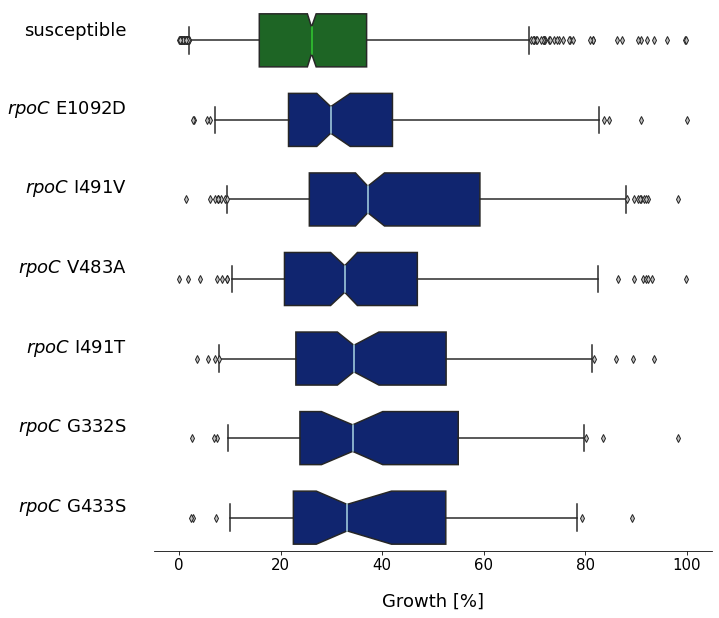

In [300]:
#set color palette
colors = palette("dark")

#load growth data for susceptibles in lineage 2
condition1 = GENOMES.WGS_PREDICTION_STRING.str[0:4].isin(['SSSS'])
condition2 = GENOMES.MYKROBE_LINEAGE_NAME_1 == 'Lineage 2'

lineage2 = GENOMES[(condition1) & (condition2)].index.to_series()
susceptible = PLATES[(PLATES.UNIQUEID.isin(lineage2.values.tolist()))].IM_POS_AVERAGE
susceptible.dropna(inplace = True)

#save p-values and medians
p_values_medians = []
p_values_medians.append(['susceptible (sus)', numpy.mean(susceptible), ' ', ' ', len(susceptible)])

fig, (ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7) = plt.subplots(7, sharex = True, 
                                                gridspec_kw = {"height_ratios": (0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15)})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.set_size_inches(10, 10)

sus_boot = my_bootstrap(susceptible)
stats = []
stats.append(['susceptible (sus)', sus_boot[0], sus_boot[1][0], sus_boot[1][1], '', '', 
              numpy.mean(susceptible), len(susceptible)])

sns.boxplot(susceptible, ax = ax_box1, color = colors[2], medianprops={"color": "LimeGreen"}, 
            usermedians = [sus_boot[0]], conf_intervals = [sus_boot[1]], **box_args)
ax_box1.set_ylabel ('susceptible', fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')

axes = [ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7]
j=0

for i, combination in enumerate(tqdm(combinations)):
    res_CM_samples = hit_samples.loc[combination]
    
    #load growth data for resistant+CMs samples in lineage 2
    resistant_CM = PLATES[(PLATES.UNIQUEID.isin(res_CM_samples.UNIQUEID.values.tolist())) 
                          & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                          == 'Lineage 2'].index.to_series()))].IM_POS_AVERAGE
    resistant_CM.dropna(inplace = True)
    
    #load growth data for resistant samples in lineage 2
    resistant = PLATES[(PLATES.UNIQUEID.isin(EFFECTS[EFFECTS.MUTATION == combination[5:10]].UNIQUEID.values.tolist())) 
                       & (~(PLATES.UNIQUEID.isin(concat_samples.UNIQUEID.values.tolist()))) 
                       & (PLATES.UNIQUEID.isin(GENOMES[GENOMES.MYKROBE_LINEAGE_NAME_1 
                                                       == 'Lineage 2'].index.to_series()))].IM_POS_AVERAGE
    resistant.dropna(inplace = True)
    
    #save p-values and medians
    if i == 0:
        p_values_medians.append(['resistant and no CMs (res)', numpy.mean(resistant), ' ', ' ', len(resistant)])
    
    if len(resistant_CM) < 50:
        continue
    
    #calculate p-values
    stat, p1 = mannwhitneyu(resistant_CM, susceptible)
    stat, p2 = mannwhitneyu(resistant_CM, resistant)
    
    #plot growth distributions below p-value cut-off
    if p1 < (0.01):
        
        ax = axes[j]
        j = j+1
        
        resCM_boot = my_bootstrap(resistant_CM)
        sns.boxplot(resistant_CM, ax = ax, color = colors[0], medianprops={"color": "LightBlue"}, 
                    usermedians = [resCM_boot[0]], conf_intervals = [resCM_boot[1]], **box_args)
               
        ax.set_ylabel ('$\it{rpoC}$' + ' ' + combination[16:], fontsize = 18, labelpad = 20, rotation=0, horizontalalignment='right')
        
        #save p-value and median
        p_values_medians.append([resistant_CM, round(numpy.mean(resistant_CM), 2), p, len(resistant_CM)])
        
        stats.append([combination[11:15] + ' ' + combination[16:], resCM_boot[0], resCM_boot[1][0], resCM_boot[1][1],
              str(p2), str(p1), round(numpy.mean(resistant_CM), 2), len(resistant_CM)])
        
#add area indicating CI of susceptible median?

#Despine plots
axes = [ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6, ax_box7]

for ax in axes:
    sns.despine(ax = ax, top = True, right=True, left = True, bottom = True, offset = False, trim = False)
    ax.tick_params(left=False, bottom=False) 
    ax.set(yticklabels=[])
    ax.set(xlabel='')

#Respine bottom plot
sns.despine(ax = ax_box7, top = True, right=True, left = True, bottom = False, offset = False, trim = False)
ax_box7.tick_params(left = False, bottom = True) 

plt.xlabel("Growth [%]", size = 18, labelpad = 20)
plt.xticks(fontsize = 15)

**Supplementary Table S5: Median growth and median confidence intervals of samples with different compensatory mutations compared to susceptibles and samples with only resistance**

In [301]:
table = pandas.DataFrame(stats, columns = ['mutation','median growth [%]', 'CI low', 'CI high', 'p-value to res', 'p-value to sus', 'mean growth [%]', 'n'], index = None)
table = table.drop(['p-value to res', 'p-value to sus', 'mean growth [%]'], axis = 1)
print(table.to_latex(index = False))

\begin{tabular}{lrrrr}
\toprule
         mutation &  median growth [\%] &  CI low &  CI high &    n \\
\midrule
susceptible (sus) &              26.08 &   25.26 &    26.99 & 1331 \\
      rpoC E1092D &              29.86 &   27.11 &    33.70 &  153 \\
       rpoC I491V &              37.17 &   34.74 &    40.46 &  360 \\
       rpoC V483A &              32.62 &   29.83 &    35.12 &  248 \\
       rpoC I491T &              34.43 &   31.18 &    39.37 &  139 \\
       rpoC G332S &              34.19 &   28.03 &    40.11 &  109 \\
       rpoC G433S &              33.09 &   27.02 &    41.84 &   82 \\
\bottomrule
\end{tabular}



**Table 2: Final list with all significantly resistance-associated putative CMs without the presumed lineage associated ones**

Excluded all mutations with over 95% of samples originating from one lineage only from downstream analysis, since they are most likely not directly resistance associated except for if they came up as clearly enhancing growth within lineage 2:
- final hit list is saved as 'hits_filtered_lineages.xlsx' and has additional columns for likely resistance association and most common lineage for samples with this mutation

In [302]:
hits_filter = pandas.read_excel('hits_filtered_lineages.xlsx')
hits_filter = hits_filter[hits_filter.directly_resistance_associated==True]
hits_final = hits[hits.other_mutation.isin(hits_filter.other_mutation)]

reference = pandas.read_excel(r'/Users/vbrunner/packages/tb-rnap-compensation/Ref_CMs.xlsx', 
                              sheet_name = 'described_CMs_binary')
reference.drop([0,1,2,3], axis = 0, inplace = True)
reference.drop(index = reference.index[-2:], axis = 0, inplace = True)

print('new CMs:', len(hits_final[~hits_final.other_mutation.isin(reference['mutation'])].other_mutation.unique()))
print('total CMs:', len(hits_final.other_mutation.unique()))

hits_final['literature evidence'] = hits_final.other_mutation.isin(reference['mutation'])
hits_final['literature evidence'] = ['\u2713' if x == True else '\u2717' for x in hits_final['literature evidence']]

growth_confirmation = ['rpoC_E1092D', 'rpoC_I491V', 'rpoC_I491T', 'rpoC_V483A', 'rpoC_V483G', 'rpoC_G332S', 'rpoC_G433S', 'rpoC_P1040R']
growth_resistance = ['rpoB_S450L']

hits_final['exp. evidence'] = hits_final.other_mutation.isin(growth_confirmation) & hits_final.resistant_mutation.isin(growth_resistance)
hits_final['exp. evidence'] = ['\u2713' if x == True else '\u2717' for x in hits_final['exp. evidence']]

hits_final = hits_final.rename(columns = {'resistant_mutation': 'resistance CM', 'other_mutation': 'putative CM'})

print(hits_final.to_latex(index = False))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/vbrunner/packages/tb-rnap-compensation/Ref_CMs.xlsx'

**Figure 4: Location of putative CMs on RNAP structure**

Done outside of this notebook, simply mapped the list of prevalence-filtered, directly resistance-associated hits onto a PyMOL structure of the TB RNA polymerase with bound Rifampicin. The crystal structure for the PyMOL file was obtained by Lin et al (pdb: 5UHB).